## Data Curation on English Wikipedia View Metrics

The goal of this notebook is to provide reproducable steps into the analysis of view metrics data provided by wikimedia foundation.
* Note:please see the Licensing details on the repository ReadMe for more details about terms of use.

In this analysis we will collect and analyze the monthly traffic metric data in the time window of January 1 2008 through September 30 2017 on English Wikipedia from two different source API servers:

- Legacy service a.k.a the legacy Pagecounts API ( [documentation] (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint] (https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)) provides access to desktop and mobile traffic data from January 2008 through July 2016. 

- Current service a.k.a The Pageviews API ([documentation] (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint] (https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through September 2017.

The following sections will include steps from data-acquisition, processing and finally analysis.


### Step I: Data Acquisition

In this section we are collecting data from both APIs and saving the results in 5 separate JSON formatted files.

In [1]:
#coding utf-8

import requests
import json


We have introduced dictionaries each including constant values that have been provided in the API documentations of current(coded as 'curr') and legacy(coded as 'legacy') API providers.

In [2]:
# representing our API sources
projects = { 'pageCounts': 'legacy', 'pageViews':'curr'}
#endpoints of current and legacy API servers
endpoint = {
    'curr' :'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}',
    'legacy' : 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
}

Each API endpoint can be accessed in multiple ways. In the legacy data, the only distinguished access types were mobile and desktop sites, however after July 2015, in order to distiguish the automated (web-crawler) access from the real-user access mechanisms, the new API provider introduced the 'agent' parameter. Thus by specifying the agent as 'user' we are able to further filter access by users.

In [3]:
#the available access mechanisms 
access = {
    'curr' : {'desktop', 'mobile-app', 'mobile-web'},
    'legacy' : {'desktop-site', 'mobile-site'}
}

date_range = {
    'legacy' : { 'start' : '2008010100', 'end' : '2016080100'},
    'curr' : { 'start' : '2015070100','end' : '2017120100'}
}

#page_count_endpoint = ''
headers={'User-Agent' : 'https://github.com/rezvanielham', 'From' : 'rezvanil@uw.edu'}

The following method constructs a dictionary of parameters based on accesstype, start and end dates and API source.
The result of this method will be used to construct the API call URLs 

In [4]:
def get_params(access, start, end, project):

    params = dict()

    if(project =='curr'):
        params['access'] = access
        params['agent'] = 'user'
    else:
        params['access-site'] = access
    params['project'] = 'en.wikipedia.org'
    params['granularity'] = "monthly"
    params['start'] = start
    params['end'] = end
    return params

This is a helper method to format the start and end dates from YYYMMDD format to YYYYMM format by eliding the day value.
The result of this method is used later in naming the output files

In [5]:
def get_ym_date(ymd_start, ymd_end):
    '''

    :param ymd_start: the start date with YYYYMMDD format
    :param ymd_end: the end date with YYYYMMDD format
    :return: the param dict of start and end dates with YYYYMM format removing the rest of the string
    '''
    params = dict()
    params['ym-start'] = ymd_start[0:6]
    params['ym-end'] = ymd_end[0:6]
    return params

This method formats the aquired 4-digit YYYYMM based on the project types (because we need different date-ranges given each API source)

In [6]:
def get_page_view_formatted_dates(project):
    return get_ym_date(date_range[project]['start'], date_range[project]['end'])

Finally at this step, we have everything to begin calling into the API endpoints and right the corresponding data to files in this format: "apiname_accesstype_firstmonth-lastmonth.json"


In [7]:
for project in projects:
   prj = projects[project]
   for acs in access[prj]:
        api_call = requests.get(endpoint[projects[project]].format(**get_params(acs, \
                                                                                date_range[prj]['start'], \
                                                                                date_range[prj]['end'], \
                                                                                prj)))
        response = api_call.json()
        #print to files with names with this format:
        out_file_name = project + '_{}_{}_{}.json'.format(acs, get_page_view_formatted_dates(prj)['ym-start'],
                                                          get_page_view_formatted_dates(prj)['ym-end'])
        json.dump(response, open(out_file_name, "w"), indent=4

)

## Step II : Data Processing

Now that we have collected the data there are a few processing steps before we can run any sort of visualization or analysis on it.

#### Page-View Data Processing Steps:
a. First step is to combine the mobile-app and mobile-web access type values from PageViews data sets into a single file.

In [8]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import datetime

#Step1: load page view mobile-app and mobile-web data into memory to combine both
pv_mobile_app_json = json.load(open(r'''pageViews_mobile-app_201507_201712.json'''))
pv_mobile_web_json = json.load(open(r'''pageViews_mobile-web_201507_201712.json'''))

#Initialize a result set
pv_mobile_combined = dict()
pv_mobile_combined['items'] = list()

for app_item in pv_mobile_app_json['items']:
    for web_item in pv_mobile_web_json['items']:
        if app_item['timestamp'] == web_item['timestamp']:
            app_item['views'] = app_item['views'] + web_item['views']
            break
    pv_mobile_combined['items'].append(app_item)

#Writing the combined result to disk
json.dump(pv_mobile_combined, open(r'''pageViews_mobile_combined_201507_201712.json''', "w"), indent=4)

b. As the next step of the processing on Page View data sets, we are going to add the month and year values to the end of each record to prepare for next steps where we want to sum up the total view counts.

The below for-loops take care of this requirement for us:

In [9]:
#adding year and month columns to the combined mobile data for page views
for combined_item in pv_mobile_combined['items']:
    combined_item['year'] = combined_item['timestamp'][0:4]
    combined_item['month'] = combined_item['timestamp'][4:6]


#load page view desktop data into memory to add the month and year columns
pv_desktop_json = json.load(open(r'''pageViews_desktop_201507_201712.json'''))
for desktop_item in pv_desktop_json['items']:
    desktop_item['year'] = desktop_item['timestamp'][0:4]
    desktop_item['month'] = desktop_item['timestamp'][4:6]

c. The final step at this level of processing the page view datasets is to combine everything into a single
data structure called: pv_total_views and make it ready for next steps. This new combined dictionary of items will have a new column to represent the summed up value of the total counts for mobile(app-web) and Desktop sites by a 'user' agent:

In [10]:
#create a list of items with a new column called total_views for page views
pv_total_views = dict()
pv_total_views['items'] = list()

#sum up the values for mobile and desktop for pageview data (adding columns according to the final result format
for mobile_item in pv_mobile_combined['items']:
    for desktop_item in pv_desktop_json['items']:
        if mobile_item['month'] == desktop_item['month'] and mobile_item['year'] == desktop_item['year']:
            #add the base item including the monthly view information for desktop first
            #we then add the following columns to match the final result format
            # 1. pageview_desktop_views columns which has the same value as the exisiting 'views' columns
            # 2. pageview_mobile_views which is the value of the 'views' from the corresponding month from mobile data
            # 3. pageview_all_views the sum of mobile and desktop views
            desktop_item['pageview_desktop_views'] = desktop_item['views']
            desktop_item['pageview_mobile_views'] = mobile_item['views']
            desktop_item['pageview_all_views'] = desktop_item['views'] + mobile_item['views']
            pv_total_views['items'].append(desktop_item)

#### Page-Count Data Processing Steps:

a.We are going to repeat the steps of adding month and year columns to page count data sets as well to facilitate the last step of suming of the total view values:

In [11]:
#load page count mobile into memory to add the year and month columns
pc_mobile_json = json.load(open(r'''pageCounts_mobile-site_200801_201608.json'''))
for mobile_item in pc_mobile_json['items']:
    mobile_item['year'] = mobile_item['timestamp'][0:4]
    mobile_item['month'] = mobile_item['timestamp'][4:6]

#load page count desktop into memory to add the year and month columns
pc_desktop_json = json.load(open(r'''pageCounts_desktop-site_200801_201608.json'''))
for desktop_item in pc_desktop_json['items']:
    desktop_item['year'] = desktop_item['timestamp'][0:4]
    desktop_item['month'] = desktop_item['timestamp'][4:6]

b. Final step at this level is to combine the total desktop-site and mobile-site view counts and add a column which represents the total-views sum in a new dicts. The below code creates the pc_total_views dictionary with all the neccasary column for the next steps:

In [12]:
#Create the final results for page count
pc_total_views = dict()
pc_total_views['items'] = list()

#sum up the values for mobile and desktop for page count data (adding columns according to the final result format
for desktop_item in pc_desktop_json['items']:
    mobViews = 0
    for mobile_item in pc_mobile_json['items']:
            if mobile_item['month'] == desktop_item['month'] and mobile_item['year'] == desktop_item['year']:
                mobViews = mobile_item['count']
    #add the base item including the monthly view information for desktop first
    #we then add the following columns to match the final result format
    # 1. pagecount_desktop_views columns which has the same value as the exisiting 'views' columns
    # 2. pagecount_mobile_views which is the value of the 'views' from the corresponding month from mobile data
    # 3. pagecount_all_views the sum of mobile and desktop views
    desktop_item['pagecount_desktop_views'] = desktop_item['count']
    desktop_item['pagecount_mobile_views'] = mobViews
    desktop_item['pagecount_all_views'] = desktop_item['count'] + mobViews
    pc_total_views['items'].append(desktop_item)

#### Create a single csv file
At this point, our current pageview results are in pv_total_views and page count results are stored in pc_total_views
we need to create a single csv file using these two sets of data given [specific format] (https://wiki.communitydata.cc/index.php?title=HCDS_(Fall_2017)/Assignments&action=edit&section=7).



In [13]:
#open a file and initialize a csv writer
with open("en-wikipedia_traffic_200801-201709.csv", "w") as fp:
    csv_writer = csv.DictWriter(fp, fieldnames= \
        ["year", "month", "pagecount_all_views", "pagecount_desktop_views",\
         "pagecount_mobile_views","pageview_all_views","pageview_desktop_views","pageview_mobile_views"])
    csv_writer.writeheader()
    #Create list of years and months going through both data sets and adding what doesnt already exist
    for pc_item in pc_total_views['items']:
        added = False
        for pv_item in pv_total_views['items']:
            if pc_item['year'] == pv_item['year'] and pc_item['month'] == pv_item['month']:
                csv_writer.writerow({'year': pc_item['year'], 'month' : pc_item['month'], \
                                     'pagecount_all_views': pc_item['pagecount_all_views'], \
                                     'pagecount_desktop_views' : pc_item['pagecount_desktop_views'], \
                                     'pagecount_mobile_views' : pc_item['pagecount_mobile_views'], \
                                     'pageview_all_views': pv_item['pageview_all_views'], \
                                     'pageview_desktop_views': pv_item['pageview_desktop_views'],\
                                     'pageview_mobile_views': pv_item['pageview_mobile_views']})
                added = True
                break

        if added == False:
            csv_writer.writerow({'year': pc_item['year'], 'month': pc_item['month'], \
                                 'pagecount_all_views': pc_item['pagecount_all_views'], \
                                 'pagecount_desktop_views': pc_item['pagecount_desktop_views'], \
                                 'pagecount_mobile_views': pc_item['pagecount_mobile_views'], \
                                 'pageview_all_views': 0, \
                                 'pageview_desktop_views': 0, \
                                 'pageview_mobile_views': 0})

At this point we have everything ready to begin our analysis on the data.

## Step III: Data Analysis

This steps is mainly about graphically presenting the processed data in order to display the monthly views data as closly as possible (replicate) the [provided sample graph] (https://wiki.communitydata.cc/upload/thumb/a/a8/PlotPageviewsEN_overlap.png/200px-PlotPageviewsEN_overlap.png).

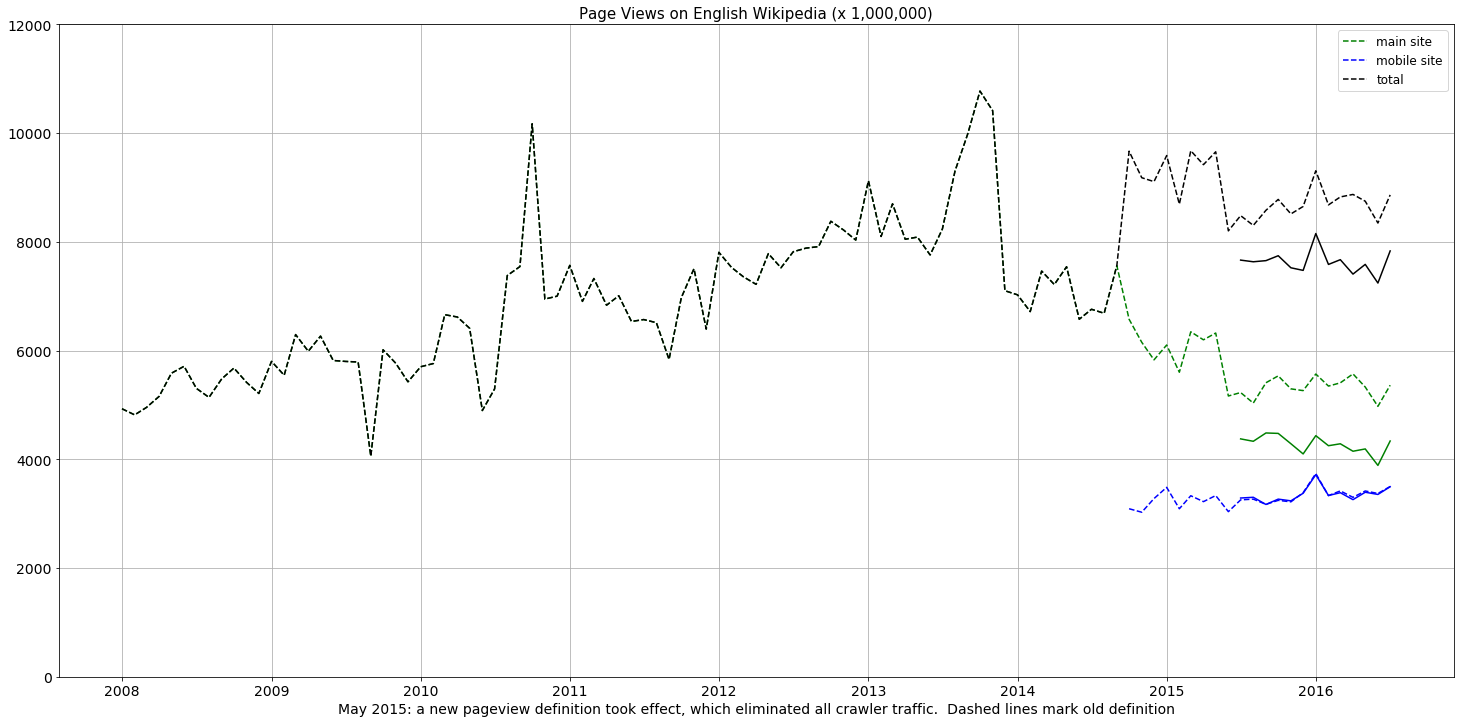

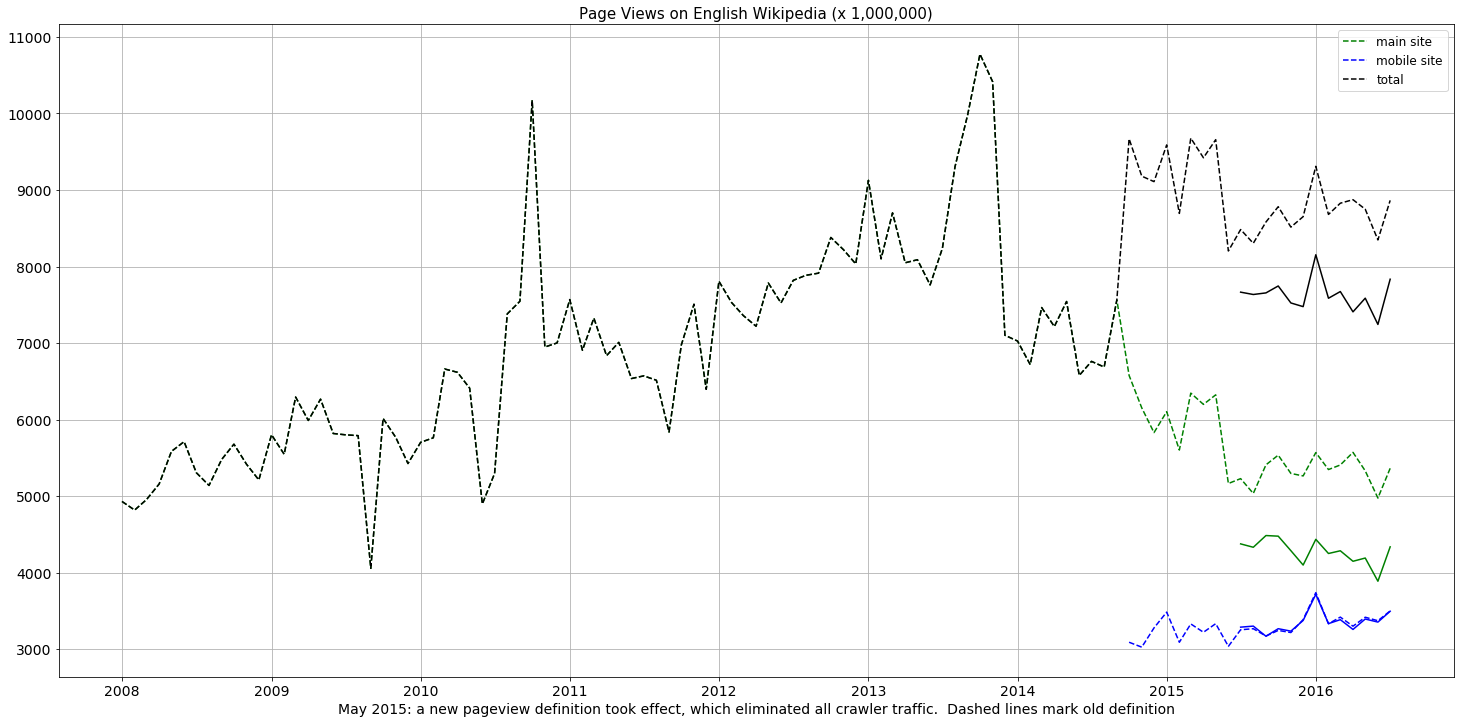

In [17]:
#now we can move to plotting step
merged_csv = pd.read_csv("en-wikipedia_traffic_200801-201709.csv")
#print(merged_csv)
plt.figure(figsize=(25, 12));

df = pd.DataFrame({'year':merged_csv['year'], 'month':merged_csv['month'], 'day':[1]*103})
dt = pd.to_datetime(df, format = '%Y%m%')

plt.plot(dt[0:103], merged_csv['pagecount_desktop_views'][0:103]/1e6,'g--', label="main site");
plt.plot(dt[81:103], merged_csv['pagecount_mobile_views'][81:103]/1e6,'b--', label="mobile site");
plt.plot(dt[0:103], merged_csv['pagecount_all_views'][0:103]/1e6,'k--', label="total");

plt.legend(['main site', 'mobile site', 'total'], fontsize = 12);

plt.plot(dt[90:103], merged_csv['pageview_desktop_views'][90:103]/1e6,'g', label="main site");
plt.plot(dt[90:103], merged_csv['pageview_mobile_views'][90:103]/1e6,'b', label="mobile site");
plt.plot(dt[90:103], merged_csv['pageview_all_views'][90:103]/1e6,'k', label="total",);

plt.title("Page Views on English Wikipedia (x 1,000,000)", fontsize = 15);
#plt.ylim((0,12000))
plt.yticks(fontsize = 14);
plt.xticks(fontsize = 14);
plt.grid(True)
plt.xlabel("May 2015: a new pageview definition took effect, which eliminated all crawler traffic.  Dashed lines mark old definition", fontsize = 14);
# Display plot
plt.show()

Save the final graph to a file:

In [18]:
plt.savefig('pageviews_english_wikipedia.png')